# Variational Mixture of Gaussians

$$
    p({\bf x}) = \sum_{k=1}^K \pi_k \mathcal{N}\left({\bf x} \vert \boldsymbol\mu_k, \boldsymbol\Sigma_k\right)
$$

In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from scipy.special import digamma
from numpy.linalg import det, inv
from scipy.stats import multivariate_normal, wishart, dirichlet
from numpy.random import seed, randn

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)
np.set_printoptions(suppress=True, precision=3)

In [3]:
url = ("https://gist.githubusercontent.com/curran/"
       "4b59d1046d9e66f2787780ad51a1cd87/raw/"
       "9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv")

In [926]:
def plot_mixtures(X, r, mu, pi, Sigma, step=0.01, cmap="viridis", levels=1):
    colors = ["tab:red", "tab:blue", "tab:green",
              "tab:cyan", "tab:orange", "tab:purple"]
    x0, y0 = X.min(axis=0)
    x1, y1 = X.max(axis=0)
    xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
    zdom = np.c_[xx.ravel(), yy.ravel()]
    Nk = r.sum(axis=0)
    
    Norms = [multivariate_normal(mean=mui, cov=Sigmai)
             for mui, Sigmai, N in zip(mu, Sigma, Nk) if N > 1]
    
    for Norm, color in zip(Norms, colors):
        density = Norm.pdf(zdom).reshape(xx.shape)
        plt.contour(xx, yy, density, levels=levels,
                    colors=color, linewidths=3)
        
    plt.scatter(*X.T, alpha=0.7, c=r.argmax(axis=1), cmap=cmap)
    plt.xlim(x0, x1)
    plt.ylim(y0, y1)

Let ${\bf X} = \{x_n\}_{n=1}^N$ a dataset of i.i.d. mixture of Gaussians with parameters $\boldsymbol \pi = \{\pi_k\}_{k=1}^K$, $\boldsymbol \mu= \{\mu_k\}_{k=1}^K$, $\boldsymbol \Lambda= \{\Lambda_k\}_{k=1}^K$ and latent variables ${\bf Z}=\{z_n\}_n$.

The likelihood distribution is defined to be

$$
\begin{aligned}
    p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) &= p({\bf x} \vert {\bf z}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p({\bf z} \vert {\boldsymbol \pi}) \\
    &= \prod_{n=1}^N\prod_{k=1}^K \mathcal{N}\left(x_n \vert \mu_k, \Lambda_k^{-1}\right)^{z_{nk}} \cdot \prod_{n=1}^N\prod_{k=1}^K \pi_k^{z_{nk}}
\end{aligned}
$$

Thus, the full joint distribution factorizes as follows:

$$
\begin{aligned}
p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) &= p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p({\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) \\
&= p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p(\boldsymbol \pi) p({\bf z} \vert \boldsymbol \pi) p(\boldsymbol \mu \vert \boldsymbol \Lambda) p(\boldsymbol \Lambda)
\end{aligned} 
$$

We now introduce conjugate priors of the form

$$
    p(\boldsymbol\pi) = \text{Dir}(\boldsymbol \pi \vert \alpha_0)
$$

$$
   p(\boldsymbol\mu\vert\boldsymbol\Lambda) = \prod_{k=1}^K \mathcal{N}\left(\mu_k\vert{\bf m}_0, (\beta_0\Lambda_k)^{-1}\right)
$$

$$
   p(\boldsymbol\Lambda) = \prod_{k=1}^K \mathcal{W}(\Lambda_k\vert{\bf W}_0, \nu_0)
$$

Next, we consider a variational distribution that factorizes between latent variables ($\bf z$) and parameters ($\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda$):

$$
    q({\bf z}, \boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda) = q({\bf z})q(\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\lambda)
$$

---

In general, a factorized variational approximation to a full joint distribution of observed variables ($\bf x$) and hidden variables ($\bf z$) satisfies

$$
    \log q_j^*(z_j) = \mathbb{E}_{m\neq j}\left[\log p({\bf x}, {\bf z})\right] + C
$$


Which involves the following computation for our problem:

$$
    \log q({\bf z}) = \mathbb{E}_{\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda}\left[\log p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda})\right] + C
$$

$$
    \log q(\boldsymbol\pi, \boldsymbol\mu, \boldsymbol\Lambda) = \mathbb{E}_{\bf z}\left[\log p({\bf x} , {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda})\right] + C
$$

It turns out that 

$$
    q^*({\bf z}) = \prod_{n=1}^N\prod_{k=1}^K r_{nk}^{z_{nk}}
$$

With 
* $r_{nk} = \frac{\rho_{nk}}{\sum_j\rho_{nj}}$,
* $\log \rho_{nk} = \mathbb{E}_{\pi}[\log \pi_k] + \frac{1}{2}\mathbb{E}_{\boldsymbol \Lambda}[\log\vert\Lambda_k\vert] - \frac{M}{2}\log 2\pi - \frac{1}{2}\mathbb{E}_{\boldsymbol \mu, \boldsymbol \Lambda}\left[(x_n - \mu_k)^T\Lambda_k(x_n - \mu_k)\right]$
    * $\mathbb{E}_{\pi}[\log \pi_k] = \psi(\alpha_k) - \psi(\hat{\boldsymbol\alpha})$
    * $\mathbb{E}_{\boldsymbol \Lambda}\left[\log\vert\Lambda_k\vert\right] = \sum_{m=1}^M\psi\left(\frac{\nu_k + 1 - M}{2}\right) + M\log2 + \log\vert{\bf w}_k\vert$
    * $\mathbb{E}_{\boldsymbol \mu, \boldsymbol \Lambda}\left[(x_n - \mu_k)^T\Lambda_k(x_n - \mu_k)\right] = \nu_k(x_n - {\bf m}_k)^T {\bf w}_k(x_n - {\bf m}_k) + M\beta^{-1}_k$


* $\psi(a) = \frac{d}{da}\Gamma(a)$
* $\hat{\boldsymbol\alpha} = \sum_k\alpha_k$

---


$$
    q^*(\boldsymbol\pi) = \text{Dir}(\boldsymbol\pi | \boldsymbol\alpha)
$$

With
* $\boldsymbol\alpha_k = \alpha_0 + N_k$

---

$$
    q^{*}(\mu_k |  \Lambda_k) = \mathcal{N}\left(\mu_k |  {\bf m}_k, (\beta_k \Lambda_k)^{-1}\right)
$$

With
* $\beta_k = \beta_0 + N_k$
* ${\bf m}_k = \frac{1}{\beta_k}(\beta_0{\bf m}_0 + N_k\bar{\bf x}_k)$

---

$$
    q^{*}(\Lambda_k) = \mathcal{W}(\Lambda_k | {\bf w}_k, \nu_k)
$$

With
* $\nu_k$ = $\nu_0 + N_k$
* ${\bf w}_k^{-1} = {\bf w}_0 + N_kS_k + \frac{\beta_0N_k}{\beta_0 + N_k}(\bar{\bf x}_k - {\bf m}_0)(\bar{\bf x}_k - {\bf m}_0)^T$


Where we have defined

$$
    N_k = \sum_{n=1}^N r_{nk} \tag{1}
$$

$$
    \bar{\bf x}_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} {\bf x}_n \tag{2}
$$

$$
    S_k = \frac{1}{N_k}\sum_{n=1}^N r_{nk} \big({\bf x}_n - \bar{\bf x}_k\big)\big({\bf x}_n - \bar{\bf x}_k\big)^T \tag{3}
$$

In [5]:
old_faithful = pd.read_table(url)

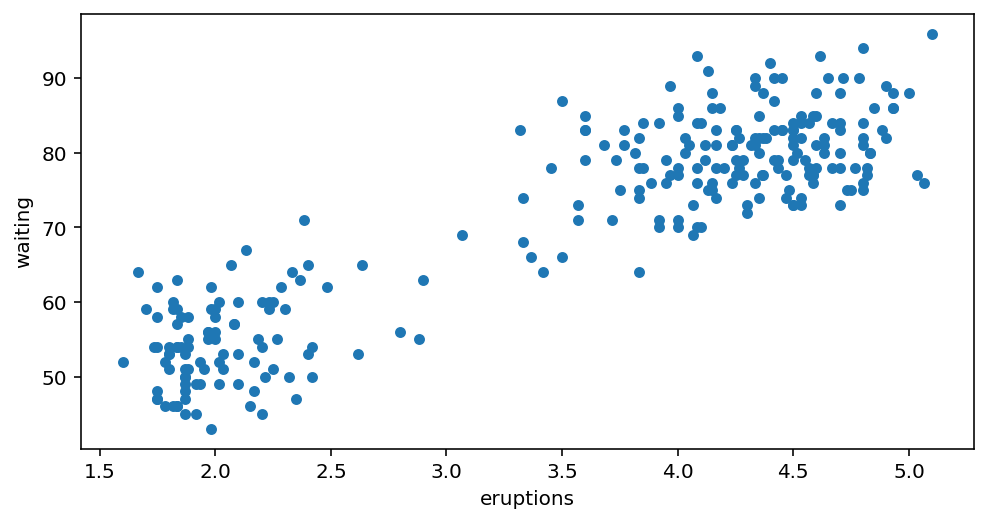

In [42]:
old_faithful.plot.scatter(x="eruptions", y="waiting")

### Variational E-step

Our first step in estimating a mixture density over the `old_faithful` dataset is to compute the responsibilities $r_{nk}$

In [121]:
X = old_faithful.values

In [122]:
# Prior parameters
N, M = X.shape
K = 6 # number of clusters
beta0 = 1
m0 = np.concatenate([X.mean(axis=0, keepdims=True).T] * 6, axis=1) # np.ones((M, K))
seed(314)
m0 = m0 + randn(2, 6) 
alpha0 = np.ones(K)
eta0 = 2 * np.ones(K)
W0 = np.concatenate([np.identity(M)[np.newaxis, ...]] * K, axis=0) / 100

In [123]:
E_logpi = digamma(alpha0) - digamma(alpha0.sum())

In [124]:
E_logLambda = digamma((eta0 + 1 - M) / 2) + M * np.log(2) + det(W0)

In [125]:
diffk = (X[:, None, :] - m0.T)
mpart = np.einsum("ijk, jkk -> ijk", diffk, W0)
E_mahal = eta0 * np.einsum("ijk, ijk -> ij", mpart, diffk) + M / beta0

In [126]:
log_rho_nk = E_logpi + E_logLambda / 2 - M / 2 * np.log(2 * np.pi) - E_mahal / 2
rho_nk = np.exp(log_rho_nk)

$r_{nk} = \frac{\rho_{nk}}{\sum_j\rho_{nj}}$

In [127]:
# Responsibilities
r_nk = rho_nk / rho_nk.sum(axis=-1, keepdims=True)

Before proceeding to the Variational M-step, it will be helpful to compute the identities $(1)$, $(2)$ and $(3)$

In [128]:
# Helpful identities
Nk = r_nk.sum(axis=0)
xbar_k = (X[..., None] * r_nk[:, None, :]).sum(axis=0) / Nk

Sk = (X[..., np.newaxis] - xbar_k)[..., None, :]
Sk = np.einsum("il, ijkl, ikjl -> kjl", r_nk, Sk, Sk) / Nk

### Variational M-step

In [129]:
alpha_k = alpha0 + Nk

In [130]:
beta_k = beta0 + Nk
m_k = (beta0 * m0 + xbar_k * Nk) / beta_k

In [131]:
eta_k = eta0 + Nk

C0 = (beta0 * Nk) / (beta0 + Nk)
f0 = (xbar_k - m0)[:, None, :]
W_k_inv = W0 + (Nk * Sk).T + np.einsum("ijk, jik -> kij", f0, f0) * C0[:, None, None ]

### Estimating the expected mixture

$$
\begin{aligned}
    p({\bf x} \vert {\bf z}, {\boldsymbol \pi}, {\boldsymbol \mu}, {\boldsymbol \lambda}) &= p({\bf x} \vert {\bf z}, {\boldsymbol \mu}, {\boldsymbol \lambda}) p({\bf z} \vert {\boldsymbol \pi}) \\
    &= \prod_{k=1}^K \mathcal{N}\left(x \vert \mu_k, \Lambda_k^{-1}\right)^{z_{nk}} 
\end{aligned}
$$


In [132]:
pi_k = dirichlet(alpha_k).mean()

In [133]:
Lambda_k = [wishart(df=eta, scale=inv(w_inv)).mean()[None, ...] for eta, w_inv in zip(eta_k, W_k_inv)]
Lambda_k = np.concatenate(Lambda_k, axis=0)

In [134]:
mu_k = [multivariate_normal(mean=m, cov=inv(L * bk)).mean[None, ...] for m, L, bk in zip(m_k.T, Lambda_k, beta_k)]
mu_k = np.concatenate(mu_k, axis=0)

In [135]:
Sigma_k = inv(beta_k[:, None, None] * Lambda_k)

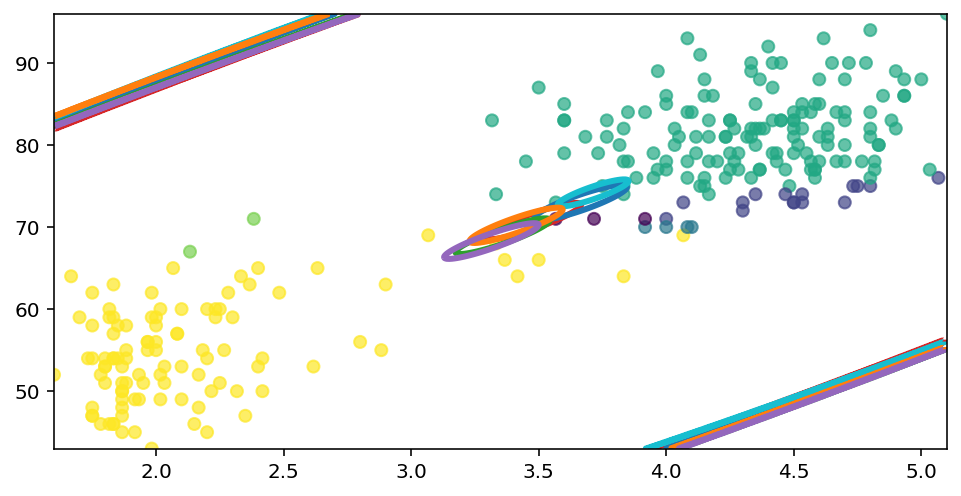

In [136]:
plot_mixtures(X, r_nk, mu_k, pi_k, Sigma_k)

##  Second Iteration

In [137]:
W_k = inv(W_k_inv)
E_logpi = digamma(alpha_k) - digamma(alpha_k.sum())
E_logLambda = digamma((eta_k + 1 - M) / 2) + M * np.log(2) + det(W_k)

In [138]:
diffk = (X[:, None, :] - m_k.T)
mpart = np.einsum("ijk, jkk -> ijk", diffk, W_k)
E_mahal = eta_k * np.einsum("ijk, ijk -> ij", mpart, diffk) + M / beta_k

In [139]:
log_rho_nk = E_logpi + E_logLambda / 2 - M / 2 * np.log(2 * np.pi) - E_mahal / 2
rho_nk = np.exp(log_rho_nk)
r_nk = rho_nk / rho_nk.sum(axis=-1, keepdims=True)

In [140]:
# Helpful identities
Nk = r_nk.sum(axis=0)
xbar_k = (X[..., None] * r_nk[:, None, :]).sum(axis=0) / Nk

Sk = (X[..., np.newaxis] - xbar_k)[..., None, :]
Sk = np.einsum("il, ijkl, ikjl -> kjl", r_nk, Sk, Sk) / Nk

In [141]:
# Helpful identities
Nk = r_nk.sum(axis=0)
xbar_k = (X[..., None] * r_nk[:, None, :]).sum(axis=0) / Nk

Sk = (X[..., np.newaxis] - xbar_k)[..., None, :]
Sk = np.einsum("il, ijkl, ikjl -> kjl", r_nk, Sk, Sk) / Nk

#### Variational M-step

In [142]:
alpha_k = alpha0 + Nk

In [143]:
beta_k = beta0 + Nk
m_k = (beta0 * m0 + xbar_k * Nk) / beta_k

In [144]:
eta_k = eta0 + Nk

C0 = (beta0 + Nk) / (beta0 * Nk)
f0 = (xbar_k - m0)[:, None, :]
W_k_inv = W0 + (Nk * Sk).T + np.einsum("ijk, jik -> kij", f0, f0) * C0[:, None, None ]

In [145]:
pi_k = dirichlet(alpha_k).mean()

### Expected Values

In [146]:
Lambda_k = [wishart(df=eta, scale=inv(w_inv)).mean()[None, ...] for eta, w_inv in zip(eta_k, W_k_inv)]
Lambda_k = np.concatenate(Lambda_k, axis=0)

In [147]:
mu_k = [multivariate_normal(mean=m, cov=inv(L * bk)).mean[None, ...] for m, L, bk in zip(m_k.T, Lambda_k, beta_k)]
mu_k = np.concatenate(mu_k, axis=0)

In [148]:
Sigma_k = inv(beta_k[:, None, None] * Lambda_k)

In [149]:
r_nk.sum(axis=0)

array([21.386, 52.045, 38.006, 78.018, 27.864, 54.68 ])

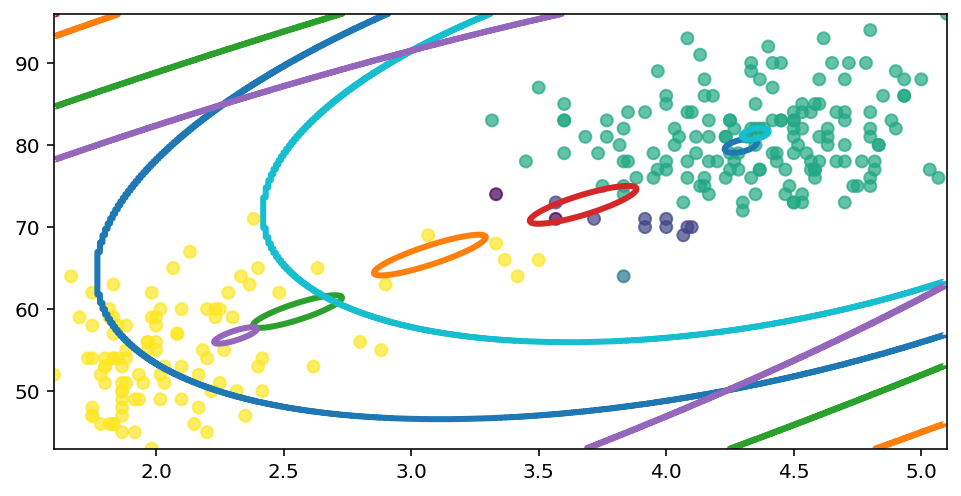

In [150]:
plot_mixtures(X, r_nk, mu_k, pi_k, Sigma_k)

# All together

In [848]:
def compute_responsibilities(X, alpha, beta, eta, m, W):
    """
    Compute model responsibilities
    (Variational E-Step)
    """
    N, M = X.shape
    E_logpi = digamma(alpha) - digamma(alpha.sum())
    E_logLambda = digamma((eta + 1 - M) / 2) + M * np.log(2) + det(W)
    diffk = (X[:, None, :] - m.T)
    mpart = np.einsum("ijk, jkk -> ijk", diffk, W)
    E_mahal = eta * np.einsum("ijk, ijk -> ij", mpart, diffk) + M / beta
    
    log_rho_nk = E_logpi + E_logLambda / 2 - M / 2 * np.log(2 * np.pi) - E_mahal / 2
    rho_nk = np.exp(log_rho_nk)
    
    # Responsibilities
    r = rho_nk / rho_nk.sum(axis=-1, keepdims=True)
    return r

def compute_m_statistics(X, r):
    Nk = r.sum(axis=0)
    xbar_k = (X[..., None] * r[:, None, :]).sum(axis=0) / Nk
    Sk = (X[..., np.newaxis] - xbar_k)[..., None, :]
    Sk = np.einsum("il, ijkl, ikjl -> kjl", r, Sk, Sk) / Nk
    
    return Nk, xbar_k, Sk


def posterior_params(X, r, alpha, beta, eta, m, W):
    """
    Compute the posterior parameters for each
    components of the mixture of gaussians
    (Variational M-Step)
    """
    Nk, xbar_k, Sk = compute_m_statistics(X, r)
    alpha_k = alpha + Nk
    beta_k = beta + Nk
    eta_k = eta + Nk
    
    m_k = (beta * m + xbar_k * Nk) / beta_k
    C0 = (beta * Nk) / (beta + Nk)
    f0 = (xbar_k - m)[:, None, :]
    W_k_inv = inv(W) + (Nk * Sk).T + np.einsum("ijk, jik -> kij", f0, f0) * C0[:, None, None]
    W_k = inv(W_k_inv)

    
    return alpha_k, beta_k, eta_k, m_k, W_k

def expected_values(X, r, alpha, beta, eta, m, W):
    pi_k = dirichlet(alpha).mean()
    Lambda_k = [wishart(df=eta_ki, scale=W_ki).mean()[None, ...]
                for eta_ki, W_ki in zip(eta, W)]
    Lambda_k = np.concatenate(Lambda_k, axis=0)
    
    mu_k = [multivariate_normal(mean=m_ki, cov=inv(bki * L)).mean[None, ...]
            for m_ki, L, bki in zip(m.T, Lambda_k, beta)]
    mu_k = np.concatenate(mu_k, axis=0)
    
    Sigma_k = inv(beta[:, None, None] * Lambda_k)
    
    return pi_k, mu_k, Sigma_k

In [1013]:
# Prior parameters
seed(314)
N, M = X.shape
K = 6 # number of clusters
beta_k = np.ones(K) * 2
m_k = np.concatenate([X.mean(axis=0, keepdims=True).T] * K, axis=1) # np.ones((M, K))
m_k = randn(M, K)
alpha_k = np.ones(K) * 10e-3
eta_k = 4 * np.ones(K)


W_k = np.concatenate([np.identity(M)[None, ...]] * K, axis=0) / 50

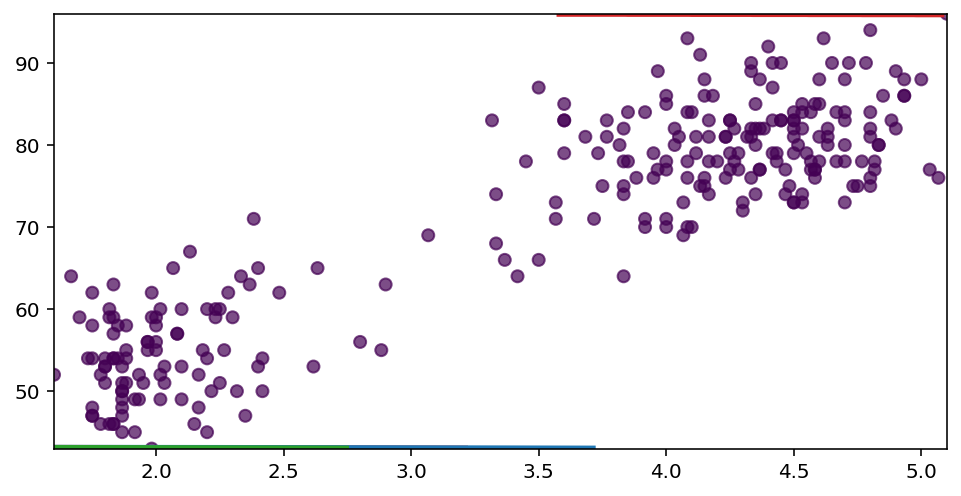

In [1014]:
r_nk = compute_responsibilities(X, alpha_k, beta_k, eta_k, m_k, W_k)
pi_k, mu_k, Sigma_k = expected_values(X, r_nk, alpha_k, beta_k, eta_k, m_k, W_k)
plot_mixtures(X, r_nk, mu_k, pi_k, Sigma_k)

In [1015]:
for _ in range(160):
    r_nk = compute_responsibilities(X, alpha_k, beta_k, eta_k, m_k, W_k)
    alpha_k, beta_k, eta_k, m_k, W_k = posterior_params(X, r_nk, alpha_k, beta_k, eta_k, m_k, W_k)

r_nk.sum(axis=0)

array([  0.001,  96.984,   0.   , 175.016,   0.   ,   0.   ])

In [1023]:
Sigma_k

array([[[  2.357,   5.778],
        [  5.778, 142.946]],

       [[  0.   ,   0.   ],
        [  0.   ,   0.002]],

       [[  5.767,   0.976],
        [  0.976,  43.452]],

       [[  0.   ,   0.   ],
        [  0.   ,   0.001]],

       [[  4.235,   8.111],
        [  8.111, 141.401]],

       [[  5.995,   0.485],
        [  0.485,  25.868]]])

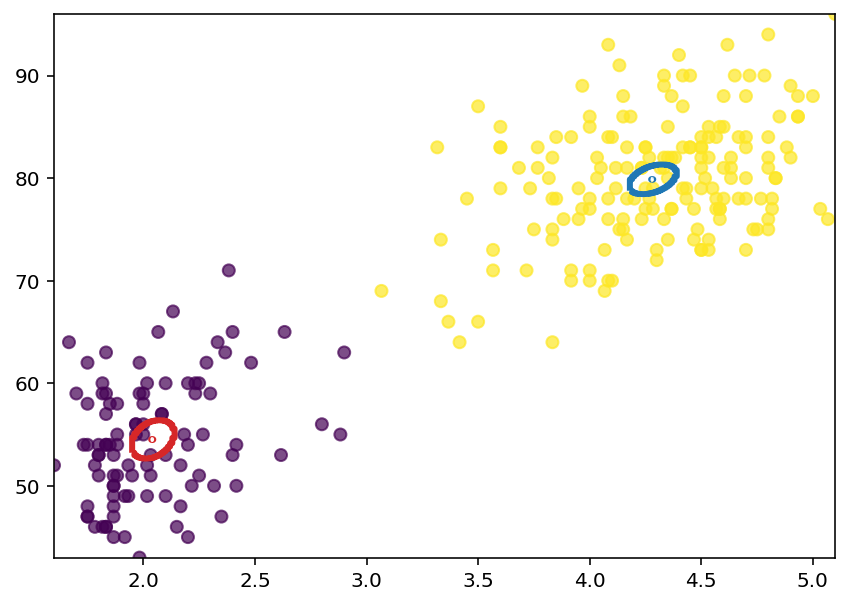

In [1019]:
plt.figure(figsize=(7, 5))
pi_k, mu_k, Sigma_k = expected_values(X, r_nk, alpha_k, beta_k, eta_k, m_k, W_k)

plot_mixtures(X, r_nk,  mu_k, pi_k, Sigma_k)